##**Data Preprocessing**

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [158]:
df = pd.read_excel('Concrete_Data.xls')

In [159]:
df.columns = ['cement', 'slag', 'ash', 'water', 'superplasticizer', 'coarse', 'fine', 'age', 'strength']

In [160]:
df = df.sample(frac=1).reset_index(drop=True)

In [161]:
df.head()

,cement,slag,ash,water,superplasticizer,coarse,fine,age,strength
0,333.0,0.0,0.00,192.00,0.00,931.20,842.60,7,23.404952
1,250.0,0.0,95.69,187.42,5.53,956.86,861.17,56,38.327971
2,332.5,142.5,0.00,228.00,0.00,932.00,594.00,90,37.721921
3,401.8,94.7,0.00,147.40,11.40,946.80,852.10,91,75.497622
4,213.5,0.0,174.24,154.61,11.66,1052.30,775.48,100,59.301831


In [162]:
df.shape

(1030, 9)

In [163]:
df.isna().sum()

,0
cement,0
slag,0
ash,0
water,0
superplasticizer,0
coarse,0
fine,0
age,0
strength,0


In [164]:
df.duplicated().sum()

25

In [165]:
df = df.drop_duplicates()

In [166]:
y = df['strength'].values
X = df.drop('strength', axis=1).values

###Heat Map (Correlation Matrix)

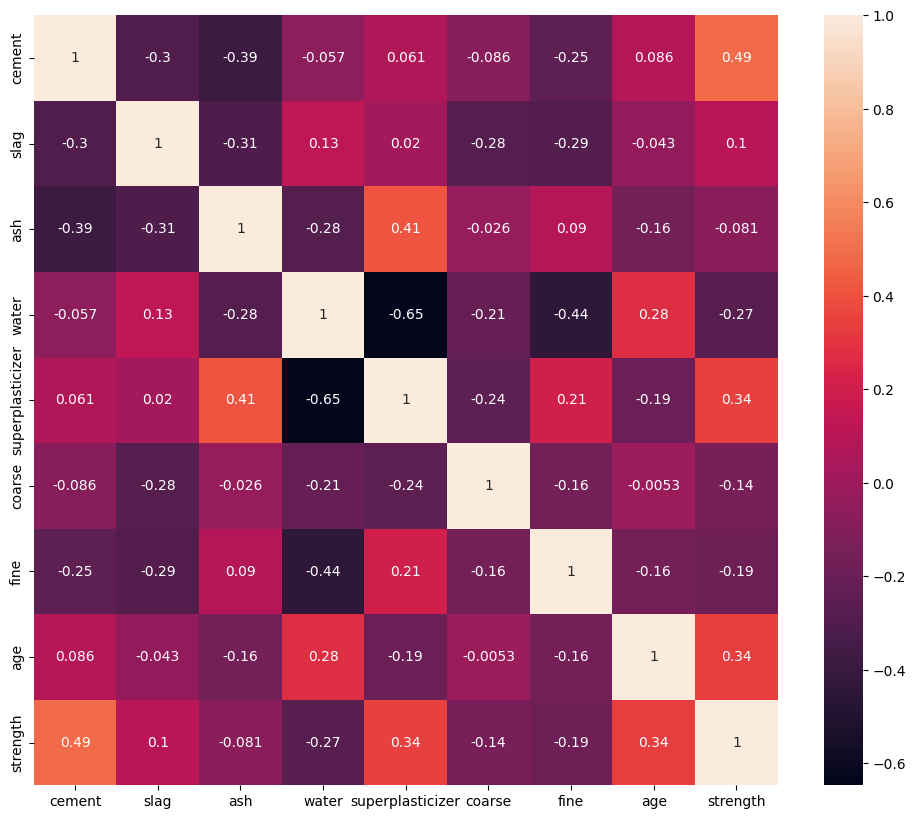

In [167]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

#### Visualization of the distribution of the target variable

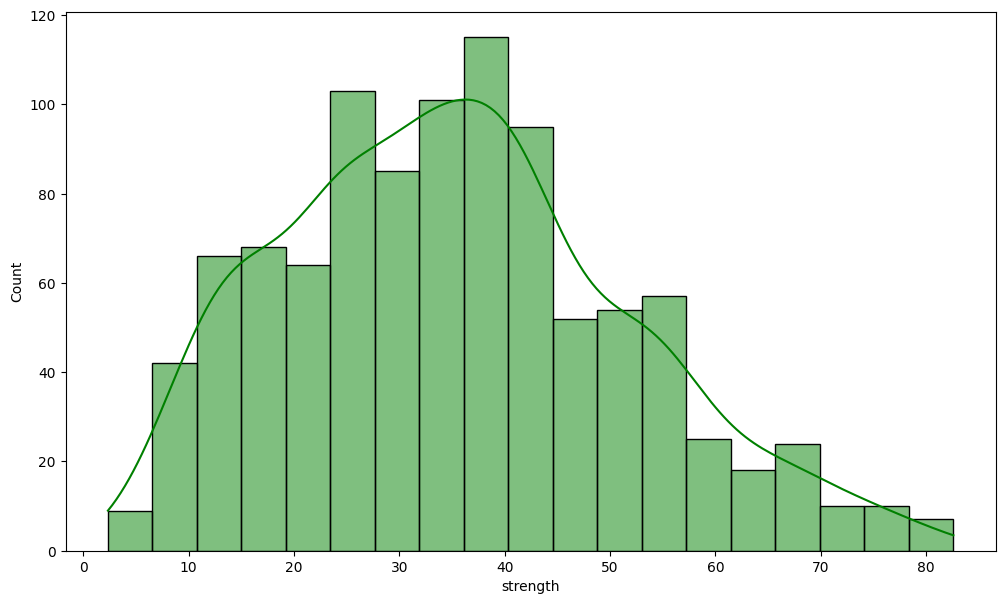

In [168]:
plt.figure(figsize=(12, 7))
sns.histplot(df['strength'], color='green', kde=True)
plt.show()

#### Visualization of the distribution of the features

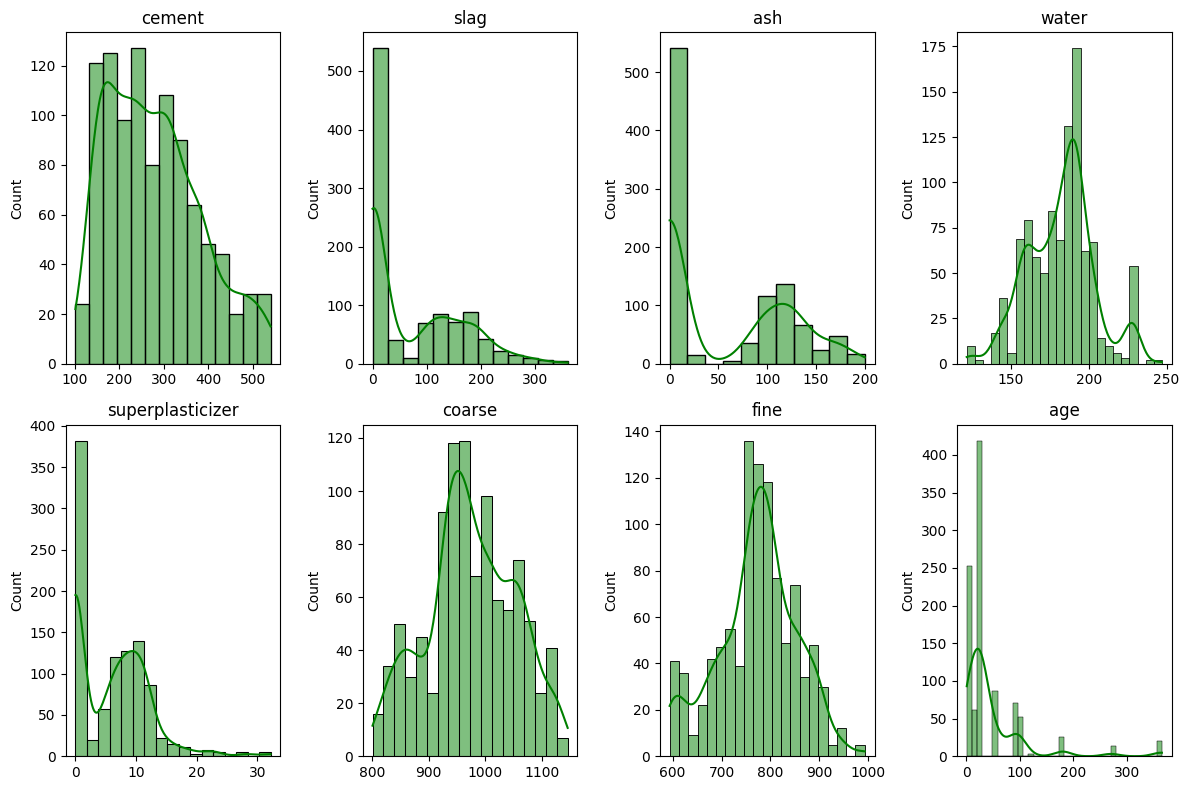

In [169]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    sns.histplot(X[:, i], kde=True, color='green', ax=ax)
    ax.set_title(df.columns[i])

plt.tight_layout()
plt.show()

#### Boxplot of the features

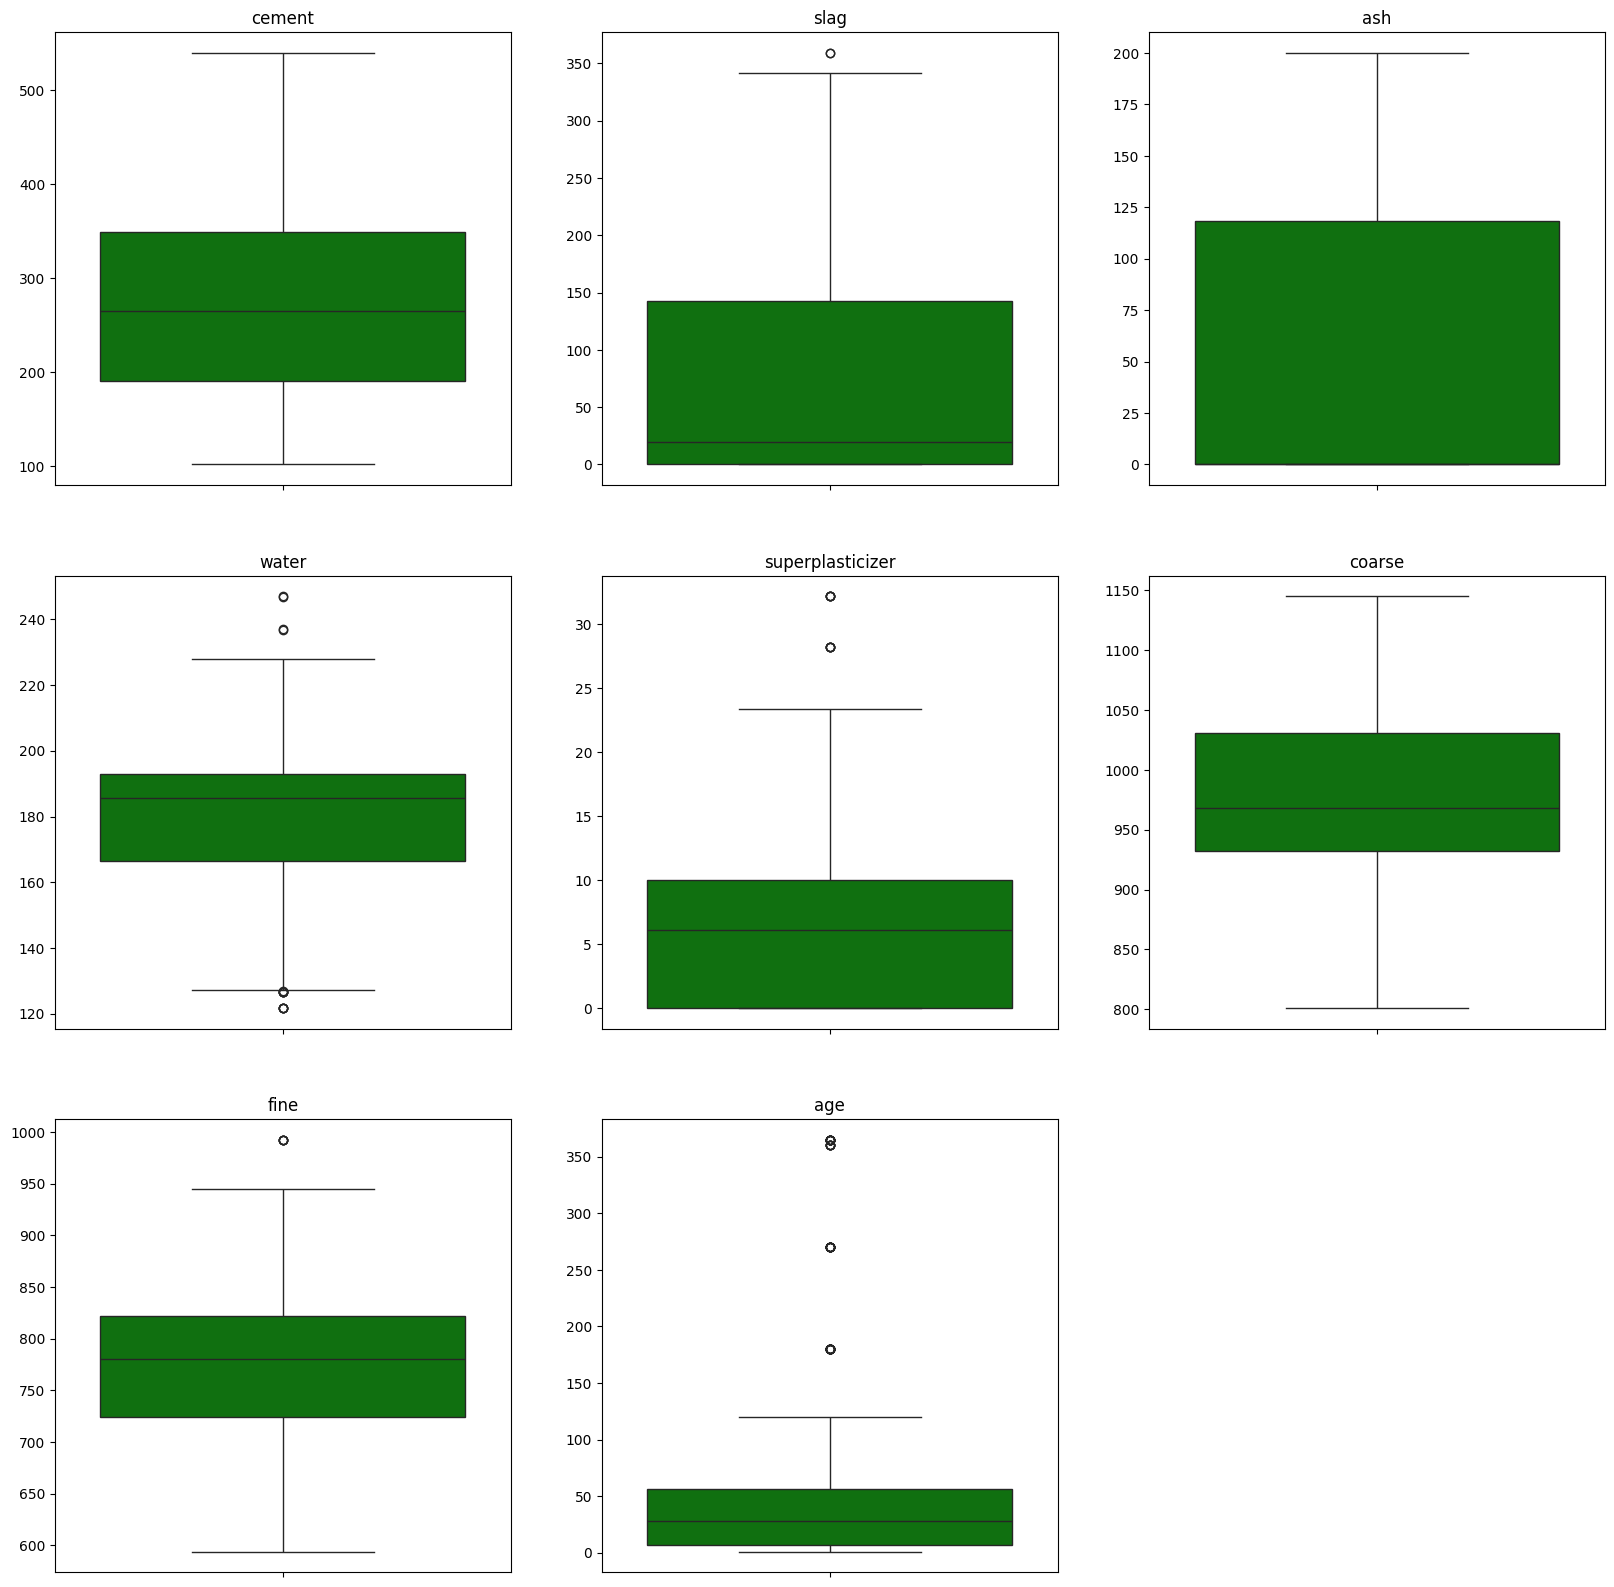

In [170]:
plt.figure(figsize=(20, 20))
for i in range(8):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=X[:, i], color='green')
    plt.title(df.columns[i])

#### Export the cleaned data

In [171]:
df.to_csv('cleaned_concrete_data.csv', index=False)

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## ***1 - Definition of a Lasso Regression***   

---
###**1.1**
Three Versions are implemented here
- Gradient descent Lasso
- ADMM Lasso
- ADMM Distributed Lasso


In [173]:
class LassoReg:
    def __init__(self, step_size, max_iterations, l1_penalty, tolerance):
        self.step_size = step_size
        self.max_iterations = max_iterations
        self.l1_penalty = l1_penalty
        self.tolerance = tolerance
        self.m = None
        self.n = None
        self.W = None
        self.X = None
        self.Y = None
        self.J = []  # Initialize J as an empty list
        self.iterations = None

    def fit(self, X, Y, algo, agents=None):
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.X = X
        self.Y = Y

        if algo == "gd":
            self.gradient_descent()
        elif algo == "admm":
            self.admm_fit()
        elif algo == "distributed_admm":
            self.distributed_admm(agents)
        else:
            raise ValueError("Invalid algorithm")

    def gradient_descent(self):
        for i in range(1, self.max_iterations + 1):
            Y_predict = self.predict(self.X).flatten()

            soft_term = self.soft_threshold(self.W, self.l1_penalty)
            dW = (-2 * self.X.T @ (self.Y - Y_predict) + soft_term) / self.m

            new_W = self.W - self.step_size * dW

            if np.linalg.norm(new_W - self.W) < self.tolerance:
                break

            self.J.append((np.linalg.norm(new_W - self.W),))
            self.W = new_W
            self.iterations = i

    def admm_fit(self):
        rho = self.step_size
        z = np.zeros(self.n)
        u = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100

        for i in range(1, self.max_iterations + 1):
            last_z = z

            self.W = np.linalg.solve(self.X.T @ self.X + rho * I, self.X.T @ self.Y + rho * (z - u))
            z = self.soft_threshold(self.W + u, self.l1_penalty / rho)
            u = u + self.W - z

            r_norm = np.linalg.norm(self.W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(self.W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * u)

            self.iterations = i
            self.J.append(np.array([r_norm, s_norm, tol_prim, tol_dual]))

            last_w = self.W.copy()
            norm_diff = np.linalg.norm(self.W - last_w) / np.linalg.norm(last_w)


            '''if (np.linalg.norm(s_norm) / rho < tol_dual and
                np.linalg.norm(r_norm) < tol_prim and
                norm_diff < abs_tol):
                break'''
            if r_norm < tol_prim and s_norm < tol_dual :
                break

        self.W = self.W.reshape(1, -1)

    def distributed_admm(self, agents):
        rho = self.step_size
        z = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100
        converged = False

        r, c = self.X.shape
        rows_per_agent = r // agents
        total_rows_used = rows_per_agent * agents

        print(f"Total rows used: {total_rows_used}")
        print(f"Rows per agent: {rows_per_agent}")

        splitted_X = self.X[:total_rows_used, :].reshape((rows_per_agent, agents, c))
        splitted_Y = np.reshape(self.Y[:total_rows_used], (rows_per_agent, agents))
        self.W = np.zeros((agents, c))
        u = np.zeros((agents, c))

        for i in range(1, self.max_iterations + 1):
            last_z = z
            for j in range(agents):
                self.W[j, :] = np.linalg.solve(splitted_X[:, j, :].T @ splitted_X[:, j, :] + (rho / 2) * I, splitted_X[:, j, :].T @ splitted_Y[:, j] + (rho / 2) * (z - u[j, :]))

            global_W = np.mean(self.W, axis=0)
            global_u = np.mean(u, axis=0)

            z = self.soft_threshold(global_W + global_u, self.l1_penalty / (rho * agents))

            for j in range(agents):
                u[j, :] = u[j, :] + (self.W[j, :] - z)

            global_u = np.mean(u, axis=0)

            r_norm = np.linalg.norm(global_W - z)
            s_norm = np.linalg.norm(-rho * (z - last_z))
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(global_W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * global_u)

            self.iterations = i
            self.J.append((r_norm, s_norm, tol_prim, tol_dual))

            last_w = self.W.copy()
            norm_diff = np.linalg.norm(self.W - last_w) / np.linalg.norm(last_w)

            '''if (np.linalg.norm(s_norm) / rho < tol_dual and
                np.linalg.norm(r_norm) < tol_prim and
                norm_diff < abs_tol):
                break'''

            if r_norm < tol_prim and s_norm < tol_dual:
                converged = True
                break

        self.W = global_W.reshape(1, -1)

    def predict(self, X):
        return X @ self.W.T.flatten()

    def loss_function(self, Y, Y_predict, W):
        return 0.5 * np.sum((Y - Y_predict) ** 2) + self.l1_penalty * np.linalg.norm(W, 1)

    def soft_threshold(self, w, th):
        return np.maximum(0, w - th) - np.maximum(0, -w - th)

    def mean_squared_error(self, Y_true, Y_predicted):
        return np.mean((Y_true - Y_predicted) ** 2)

### **1.2 - Definition of Plot Functions**

In [174]:
def prediction_plot(Y_test, Y_pred, title):
    plt.scatter(Y_test, Y_pred, color='purple', label='Predicted vs. Measured')
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4, label='Ideal')
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

def loss_plot(J, title):
    plt.plot(J, color='orange', label='Total Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

def loss_plot_admm(J, title):
    r_loss = [row[0] for row in J]
    s_loss = [row[1] for row in J]

    plt.plot(r_loss, label='Primary Residual', color='purple')
    plt.plot(s_loss, label='Dual Residual', color='green')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

In [175]:
def loss_plot_admm_val(ax, loss_data, title):
    ax.plot(np.arange(1, len(loss_data) + 1), np.array(loss_data)[:, 0], label='Primal Residual', color = 'purple')
    ax.plot(np.arange(1, len(loss_data) + 1), np.array(loss_data)[:, 1], label='Dual Residual', color = 'green')
    ax.set_xlabel('Iterazioni')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()

def loss_plot_distributed_admm_val(ax, lasso_model, title):
    r_loss = [row[0] for row in lasso_model.J]
    s_loss = [row[1] for row in lasso_model.J]

    ax.plot(np.arange(1, len(lasso_model.J) + 1), r_loss, label='Primary Residual', color='purple')
    ax.plot(np.arange(1, len(lasso_model.J) + 1), s_loss, label='Dual Residual', color='green')

    ax.set_xlabel('Iterazioni')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()

## ***2 - Implementation on Real Dataset***
###2.1 - Importing Dataset


In [176]:
import os
parent_folder = os.path.dirname(os.getcwd())
data_folder = "Data"
dataset_name = "/content/cleaned_concrete_data.csv"
dataset_path = os.path.join(parent_folder, data_folder, dataset_name)

df_real = pd.read_csv(dataset_path)

In [177]:
print(df_real.head())
print(df_real.shape)

   cement   slag     ash   water  superplasticizer   coarse    fine  age  \
0   333.0    0.0    0.00  192.00              0.00   931.20  842.60    7   
1   250.0    0.0   95.69  187.42              5.53   956.86  861.17   56   
2   332.5  142.5    0.00  228.00              0.00   932.00  594.00   90   
3   401.8   94.7    0.00  147.40             11.40   946.80  852.10   91   
4   213.5    0.0  174.24  154.61             11.66  1052.30  775.48  100   

    strength  
0  23.404952  
1  38.327971  
2  37.721921  
3  75.497622  
4  59.301831  
(1005, 9)


In [178]:
X_real = df_real.drop('strength', axis=1).values
y_real = df_real['strength'].values

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

###Data Normalization

In [179]:
scaler = MinMaxScaler()
X_train_real = scaler.fit_transform(X_train_real)
X_test_real = scaler.transform(X_test_real)

In [180]:
step_size = 0.01
l1_penalty = 0.1
max_iterations = 100000
tolerance = 1e-3

###**4.2- Training and testing the model on the dataset evaluating the impact of the choice of parameters**
####4.2.1 - Lasso Gradient Descent
Validation of step_size parameter

In [181]:
step_sizes = [0.001, 0.01, 0.1, 0.5]

for step_size in step_sizes:
    start_time = time.time()

    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train_real, y_train_real, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with step_size {step_size}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with step_size {step_size}: {iterations_gd}")

    y_pred_gd = lasso_gd.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_gd)
    print(f"R^2 with step_size {step_size}: {r2}")

GD time with step_size 0.001: 0.6861650943756104
GD iterations with step_size 0.001: 19862
R^2 with step_size 0.001: 0.5451140048167373
GD time with step_size 0.01: 0.3478972911834717
GD iterations with step_size 0.01: 10974
R^2 with step_size 0.01: 0.6026102917830267
GD time with step_size 0.1: 0.08219265937805176
GD iterations with step_size 0.1: 2565
R^2 with step_size 0.1: 0.6045719465247781
GD time with step_size 0.5: 0.023685693740844727
GD iterations with step_size 0.5: 717
R^2 with step_size 0.5: 0.6046448652590544


In [182]:
step_size = 0.5
l1_penalties = [0.01, 0.1, 1, 10]

for l1_penalty in l1_penalties:
    start_time = time.time()

    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train_real, y_train_real, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with l1_penalty {l1_penalty}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with l1_penalty {l1_penalty}: {iterations_gd}")

    y_pred_gd = lasso_gd.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_gd)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

GD time with l1_penalty 0.01: 0.024893999099731445
GD iterations with l1_penalty 0.01: 717
R^2 with l1_penalty 0.01: 0.6046413975957808
GD time with l1_penalty 0.1: 0.024039506912231445
GD iterations with l1_penalty 0.1: 717
R^2 with l1_penalty 0.1: 0.6046448652590544
GD time with l1_penalty 1: 0.024356603622436523
GD iterations with l1_penalty 1: 717
R^2 with l1_penalty 1: 0.6046793290541046
GD time with l1_penalty 10: 0.02535390853881836
GD iterations with l1_penalty 10: 721
R^2 with l1_penalty 10: 0.605047387731353


#### 4.2.2 - Lasso ADMM
Validation of step_size parameter

ADMM time with step_size 0.001: 0.002093791961669922
ADMM iterations with step_size 0.001: 15
R^2 with step_size 0.001: 0.6061195219315455
ADMM time with step_size 0.01: 0.000644683837890625
ADMM iterations with step_size 0.01: 4
R^2 with step_size 0.01: 0.6061198141460775
ADMM time with step_size 0.1: 0.00048351287841796875
ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.6061197602933442
ADMM time with step_size 0.5: 0.0006456375122070312
ADMM iterations with step_size 0.5: 4
R^2 with step_size 0.5: 0.6061197845720198


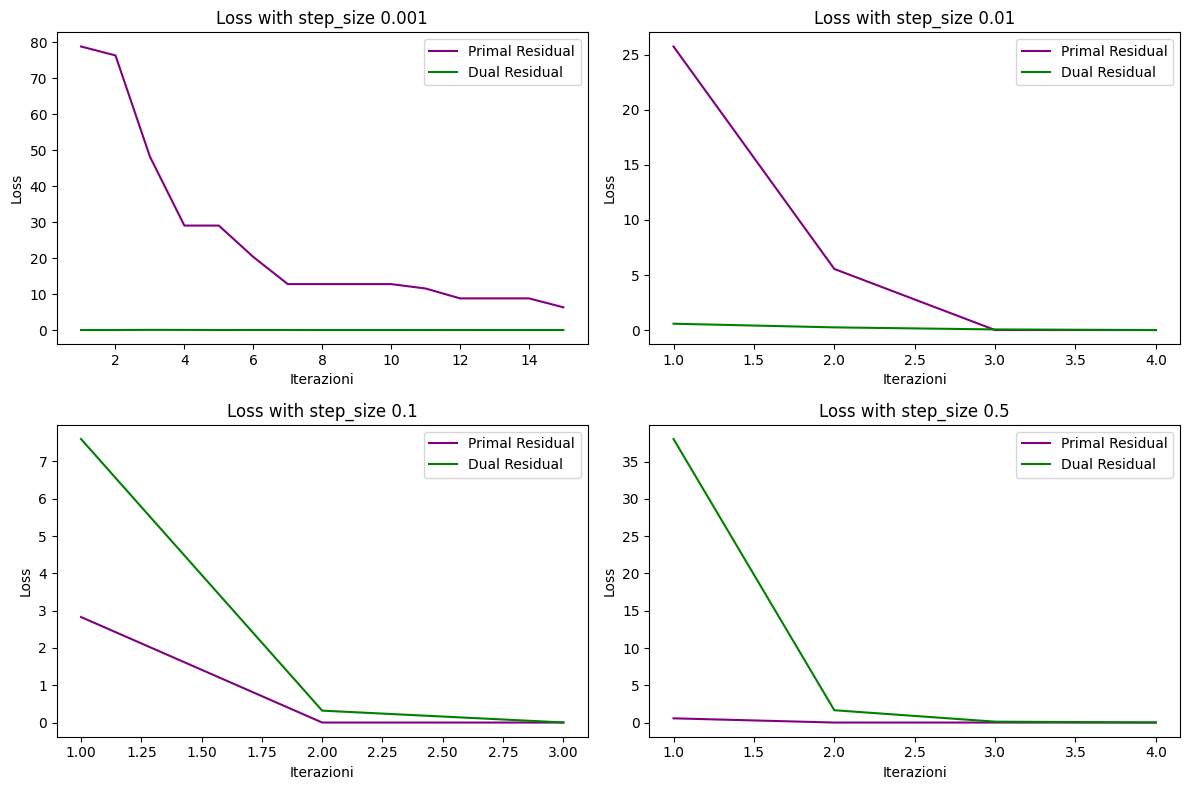

In [183]:
l1_penalty = 0.1
step_sizes = [0.001, 0.01, 0.1, 0.5]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train_real, y_train_real, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with step_size {step_size}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with step_size {step_size}: {iterations_admm}")

    y_pred_admm = lasso_admm.predict(X_test_real)

    r2 = 1 - np.mean((y_test_real - y_pred_admm) ** 2) / np.var(y_test_real)
    print(f"R^2 with step_size {step_size}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

ADMM time with l1_penalty 0.01: 0.0023272037506103516
ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.60612420769304
ADMM time with l1_penalty 0.1: 0.0005230903625488281
ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.6061197602933441
ADMM time with l1_penalty 1: 0.0006425380706787109
ADMM iterations with l1_penalty 1: 4
R^2 with l1_penalty 1: 0.6060748294289826
ADMM time with l1_penalty 10: 0.00201416015625
ADMM iterations with l1_penalty 10: 15
R^2 with l1_penalty 10: 0.6055038247438183


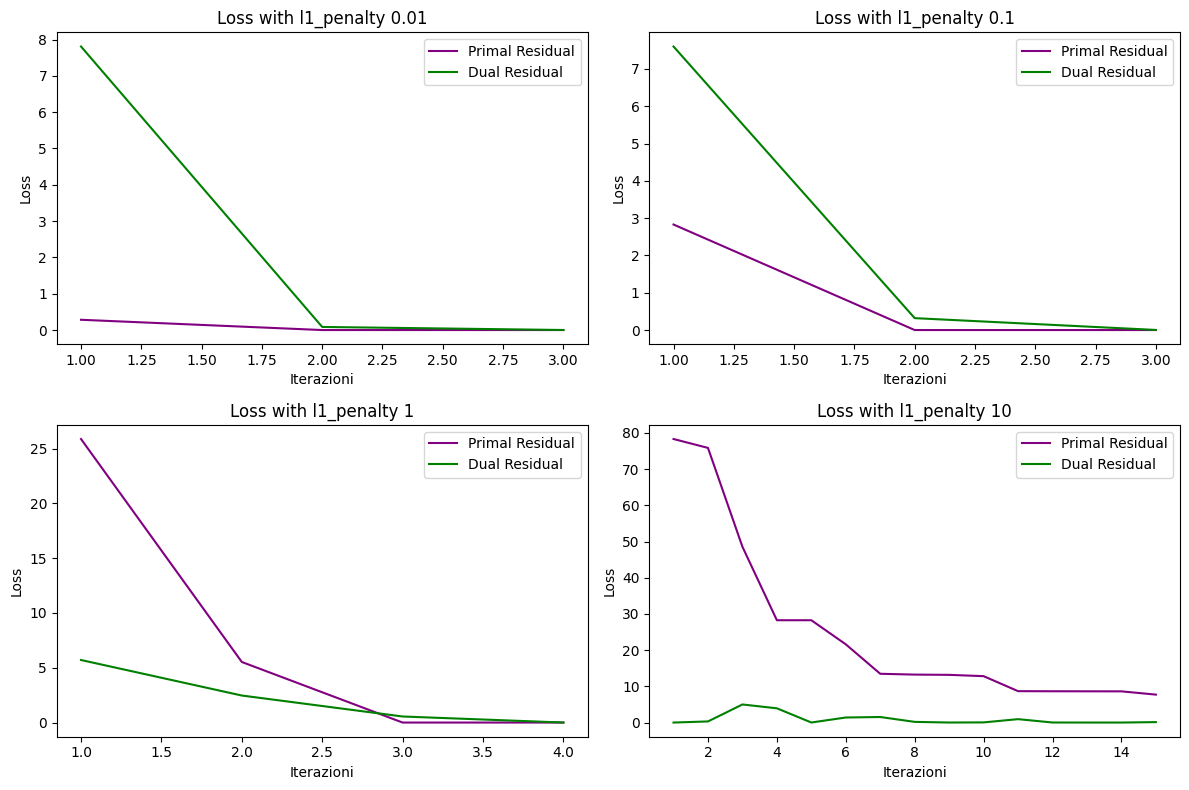

In [184]:
step_size = 0.1
l1_penalties = [0.01, 0.1, 1, 10]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()

    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train_real, y_train_real, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with l1_penalty {l1_penalty}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with l1_penalty {l1_penalty}: {iterations_admm}")

    y_pred_admm = lasso_admm.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()

plt.show()

#### 4.2.3 - Lasso Distributed ADMM
Validation of step_size parameter

Total rows used: 804
Rows per agent: 268
Distributed ADMM time with step_size 0.001: 0.0070743560791015625
Distributed ADMM iterations with step_size 0.001: 6
R^2 with step_size 0.001: 0.607440432055731
Total rows used: 804
Rows per agent: 268
Distributed ADMM time with step_size 0.01: 0.005905628204345703
Distributed ADMM iterations with step_size 0.01: 3
R^2 with step_size 0.01: 0.6074395445061715
Total rows used: 804
Rows per agent: 268
Distributed ADMM time with step_size 0.1: 0.00445246696472168
Distributed ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.6074293607295241
Total rows used: 804
Rows per agent: 268
Distributed ADMM time with step_size 0.5: 0.007544279098510742
Distributed ADMM iterations with step_size 0.5: 5
R^2 with step_size 0.5: 0.6073410927830838


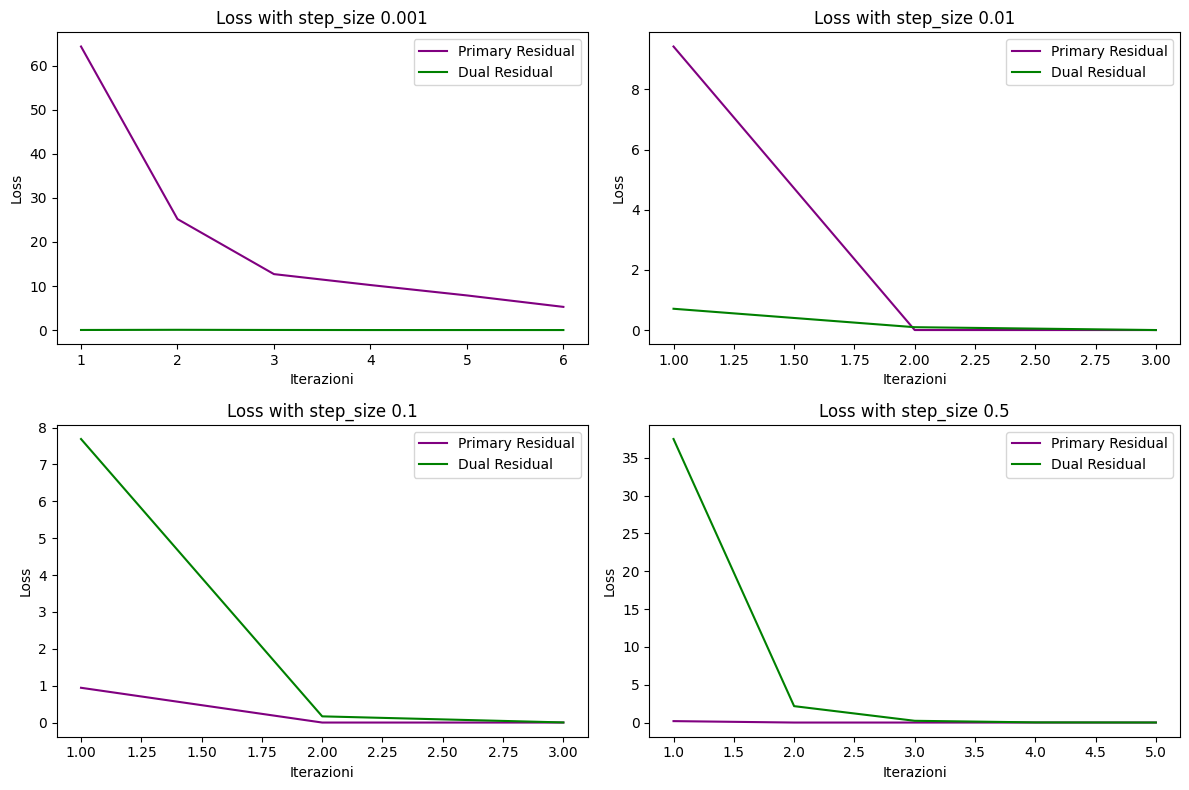

In [185]:
step_sizes = [0.001, 0.01, 0.1, 0.5]
l1_penalty = 0.1
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_real, y_train_real, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with step_size {step_size}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with step_size {step_size}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_distributed_admm)
    print(f"R^2 with step_size {step_size}: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

Total rows used: 804
Rows per agent: 268
Distributed ADMM time with l1_penalty 0.01: 0.012857198715209961
Distributed ADMM iterations with l1_penalty 0.01: 24
R^2 with l1_penalty 0.01: 0.6069893328118325
Total rows used: 804
Rows per agent: 268
Distributed ADMM time with l1_penalty 0.1: 0.008806705474853516
Distributed ADMM iterations with l1_penalty 0.1: 5
R^2 with l1_penalty 0.1: 0.6073410927830838
Total rows used: 804
Rows per agent: 268
Distributed ADMM time with l1_penalty 1: 0.0021262168884277344
Distributed ADMM iterations with l1_penalty 1: 4
R^2 with l1_penalty 1: 0.6073340576072226
Total rows used: 804
Rows per agent: 268
Distributed ADMM time with l1_penalty 10: 0.0018460750579833984
Distributed ADMM iterations with l1_penalty 10: 3
R^2 with l1_penalty 10: 0.6070509290365753


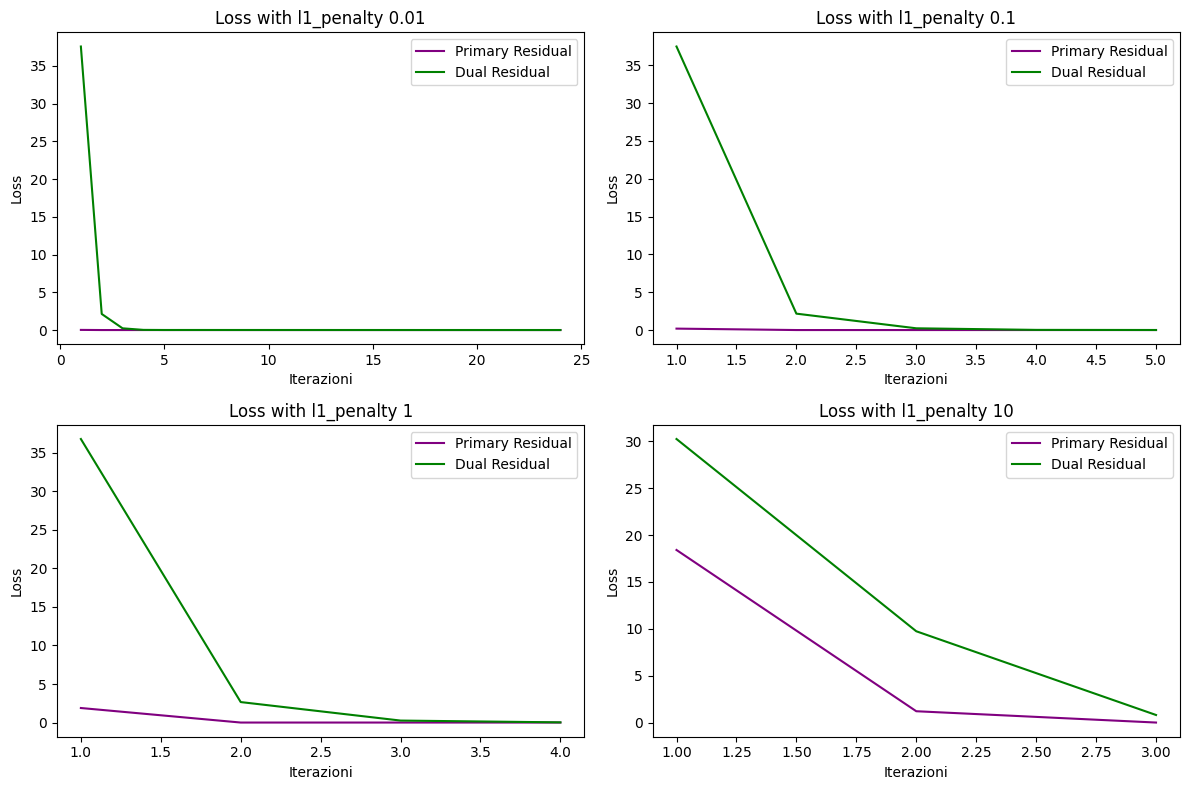

In [186]:
step_size = 0.5
l1_penalties = [0.01, 0.1, 1, 10]
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_real, y_train_real, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with l1_penalty {l1_penalty}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with l1_penalty {l1_penalty}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_distributed_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()

plt.show()

Total rows used: 804
Rows per agent: 268
Distributed ADMM time with 3 agents: 0.009776115417480469
Distributed ADMM iterations with 3 agents: 24
R^2 with 3 agents: 0.6069893328118325
Total rows used: 800
Rows per agent: 160
Distributed ADMM time with 5 agents: 0.06341767311096191
Distributed ADMM iterations with 5 agents: 77
R^2 with 5 agents: 0.607058131635311
Total rows used: 800
Rows per agent: 80
Distributed ADMM time with 10 agents: 0.05271577835083008
Distributed ADMM iterations with 10 agents: 84
R^2 with 10 agents: 0.6060836753813422
Total rows used: 800
Rows per agent: 40
Distributed ADMM time with 20 agents: 0.06986665725708008
Distributed ADMM iterations with 20 agents: 57
R^2 with 20 agents: 0.6064937010136507


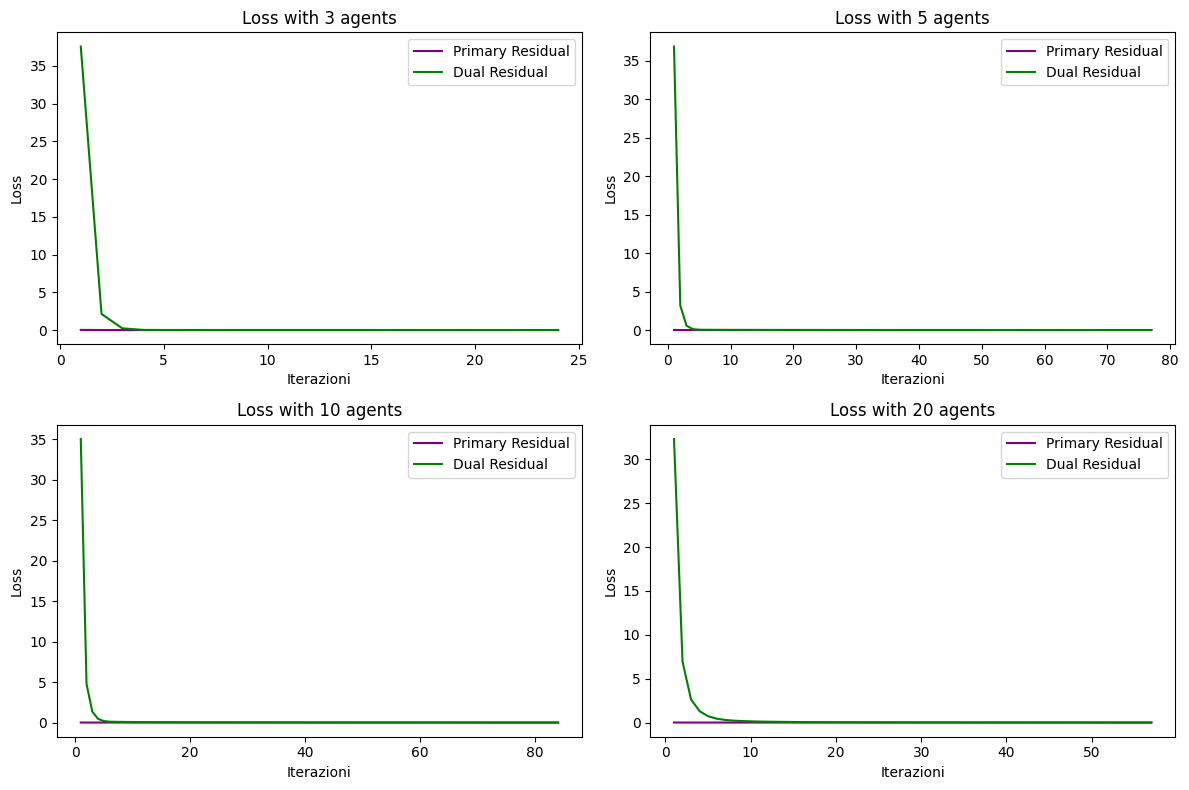

In [187]:
step_size = 0.5
l1_penalty = 0.01
agents = [3, 5, 10, 20]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, agent in enumerate(agents, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_real, y_train_real, algo="distributed_admm", agents=agent)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with {agent} agents: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with {agent} agents: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_distributed_admm)
    print(f"R^2 with {agent} agents: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with {agent} agents')

plt.tight_layout()

plt.show()

#### 4.2.4 - Comaparisons of Lasso versions
Gradient Descent

GD time: 0.030349254608154297
GD iterations: 721
R^2: 0.605047387731353
MSE: 111.84832946361817
MAE: 8.39523251924217


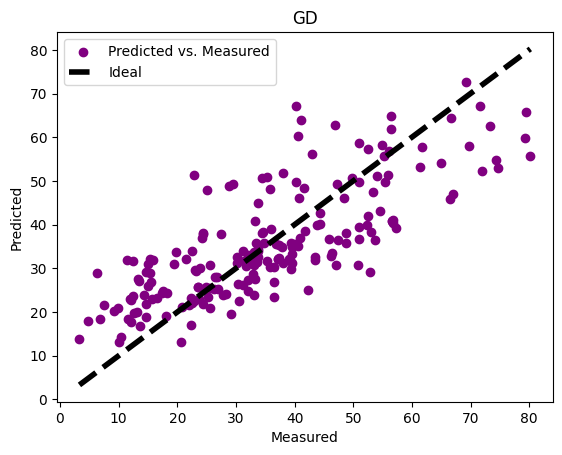

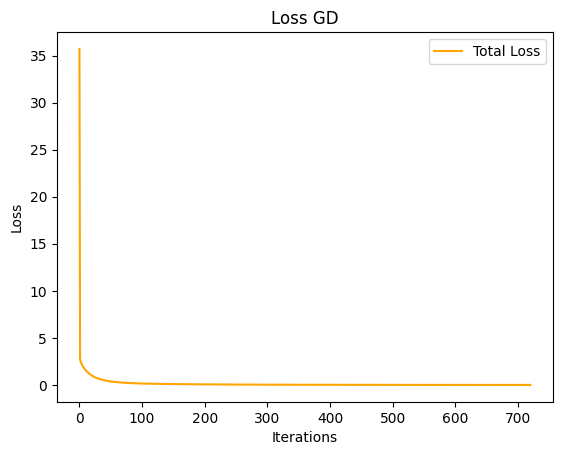

In [188]:
# Parameters
step_size = 0.5
l1_penalty = 10

# GD
start_time = time.time()
lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_gd.fit(X_train_real, y_train_real, algo="gd")
gd_time = time.time() - start_time
print(f"GD time: {gd_time}")

iterations_gd = lasso_gd.iterations
print(f"GD iterations: {iterations_gd}")

y_pred_gd = lasso_gd.predict(X_test_real)

# Metrics
r2_gd = r2_score(y_test_real, y_pred_gd)
print(f"R^2: {r2_gd}")

mse_gd = mean_squared_error(y_test_real, y_pred_gd)
print(f"MSE: {mse_gd}")
mae_gd = mean_absolute_error(y_test_real, y_pred_gd)
print(f"MAE: {mae_gd}")

# Plots
prediction_plot(y_test_real, y_pred_gd, "GD")
loss_plot(lasso_gd.J, "Loss GD")

ADMM

ADMM time: 0.0008652210235595703
ADMM iterations: 3
R^2: 0.6061197602933441
MSE: 111.54463966414484
MAE: 8.374771709246117


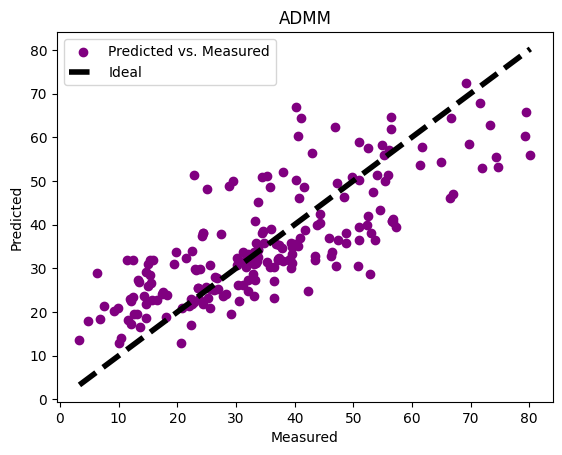

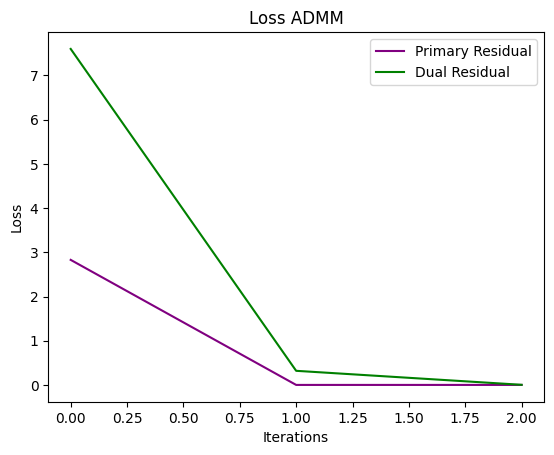

In [189]:
# Parameters
step_size = 0.1
l1_penalty = 0.1

# ADMM
start_time = time.time()
lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train_real, y_train_real, algo="admm")
admm_time = time.time() - start_time
print(f"ADMM time: {admm_time}")

iterations_admm = lasso_admm.iterations
print(f"ADMM iterations: {iterations_admm}")

y_pred_admm = lasso_admm.predict(X_test_real)

# Metrics
r2_admm = r2_score(y_test_real, y_pred_admm)
print(f"R^2: {r2_admm}")

mse_admm = mean_squared_error(y_test_real, y_pred_admm)
print(f"MSE: {mse_admm}")
mae_admm = mean_absolute_error(y_test_real, y_pred_admm)
print(f"MAE: {mae_admm}")

# Plots
prediction_plot(y_test_real, y_pred_admm, "ADMM")
loss_plot_admm(lasso_admm.J, "Loss ADMM")

Total rows used: 800
Rows per agent: 160
Distributed ADMM time: 0.07390522956848145
Distributed ADMM iterations: 77
R^2: 0.607058131635311
MSE: 111.27889824668051
MAE: 8.359085946346694


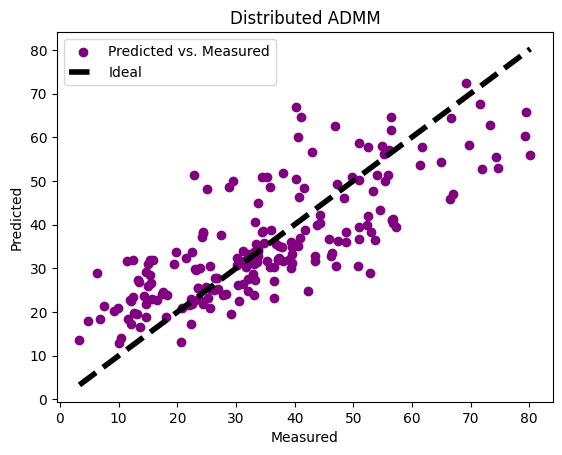

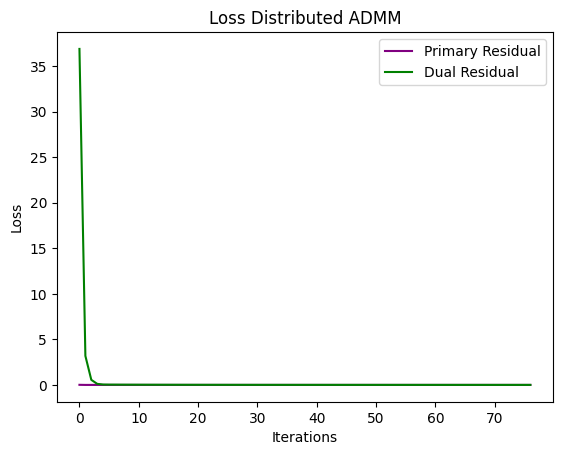

In [190]:
# Parameters
step_size = 0.5
l1_penalty = 0.01
agents = 5

# Distributed ADMM
start_time = time.time()
lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_distributed_admm.fit(X_train_real, y_train_real, algo="distributed_admm", agents=agents)
distributed_admm_time = time.time() - start_time
print(f"Distributed ADMM time: {distributed_admm_time}")

iterations_distributed_admm = lasso_distributed_admm.iterations
print(f"Distributed ADMM iterations: {iterations_distributed_admm}")

y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_real)

# Metrics
r2_distributed_admm = r2_score(y_test_real, y_pred_distributed_admm)
print(f"R^2: {r2_distributed_admm}")

mse_distributed_admm = mean_squared_error(y_test_real, y_pred_distributed_admm)
print(f"MSE: {mse_distributed_admm}")
mae_distributed_admm = mean_absolute_error(y_test_real, y_pred_distributed_admm)
print(f"MAE: {mae_distributed_admm}")

# Plots
prediction_plot(y_test_real, y_pred_distributed_admm, "Distributed ADMM")
loss_plot_admm(lasso_distributed_admm.J, "Loss Distributed ADMM")
